In [1]:
import glob 
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Laplace
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

import poisevae
from poisevae.datasets import CUB
from poisevae.utils import NN_lookup, Categorical
from poisevae.networks.CUBNetworks import EncImg, DecImg, EncTxt, DecTxt

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [2]:
HOME_PATH = os.path.expanduser('~')
DATA_PATH = os.path.join(HOME_PATH, 'Datasets/CUB/')

In [3]:
tx = lambda data: torch.Tensor(data)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
CUB_train = CUB(DATA_PATH, DATA_PATH, 'train', device, tx, return_idx=False)
CUB_test = CUB(DATA_PATH, DATA_PATH, 'test', device, tx, return_idx=True)

In [6]:
vocab_size, txt_len = CUB_train.CUBtxt.vocab_size, CUB_train.CUBtxt.max_sequence_length
vocab_size, txt_len

(1590, 32)

In [7]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(CUB_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(CUB_test, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(692, 230)

In [8]:
enc_img = EncImg(128).to(device)
dec_img = DecImg(128).to(device)
enc_txt = EncTxt(vocab_size, 128).to(device)
dec_txt = DecTxt(vocab_size, 128).to(device)
    
rec_weights = [1, 1] # [1, 2048/txt_len]
vae = poisevae.POISEVAE([enc_img, enc_txt], [dec_img, dec_txt], likelihoods=[Laplace, Categorical], 
                        latent_dims=[128, (128, 1, 1)], rec_weights=rec_weights).to(device)

In [12]:
# for i in vae.named_parameters():
#     print(i[0])

In [13]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3, amsgrad=True)

In [14]:
from datetime import datetime
PATH = os.path.join('runs/CUB', datetime.now().strftime('%y%m%d%H%M'))
if os.path.exists(PATH):
        raise ValueError

In [15]:
epoch = 0
# try:
#     vae, optimizer, epoch = poisevae.utils.load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [16]:
writer = SummaryWriter(PATH)

In [17]:
epochs = 50 + epoch
for epoch in tqdm(range(epoch, epochs)):
    poisevae.utils.train(vae, train_loader, optimizer, epoch, writer)
    labels, latent_info = poisevae.utils.test(vae, test_loader, epoch, writer, 
                                              record_idx=(-1,), return_latents=True)
    if (epoch+1) % 10 == 0 and epoch > 0:
        poisevae.utils.save_checkpoint(vae, optimizer, os.path.join(PATH, 'training_%d.pt' % (epoch+1)), epoch+1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [44:28<00:00, 53.37s/it]


In [18]:
writer.flush()
writer.close()

In [19]:
# poisevae.utils.save_latent_info(latent_info, PATH)

## Results

In [9]:
PATH = 'runs/CUB/worew'
vae, _, epoch = poisevae.utils.load_checkpoint(vae, load_path=sorted(glob.glob(os.path.join(PATH, 'train*.pt')))[-1])
epoch

50

### Reconstruction

In [10]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), txt.to(device)])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

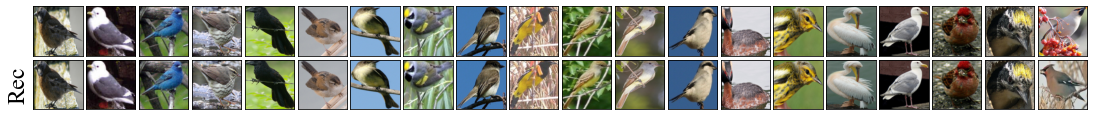

In [11]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgRec.pdf'), dpi=300)

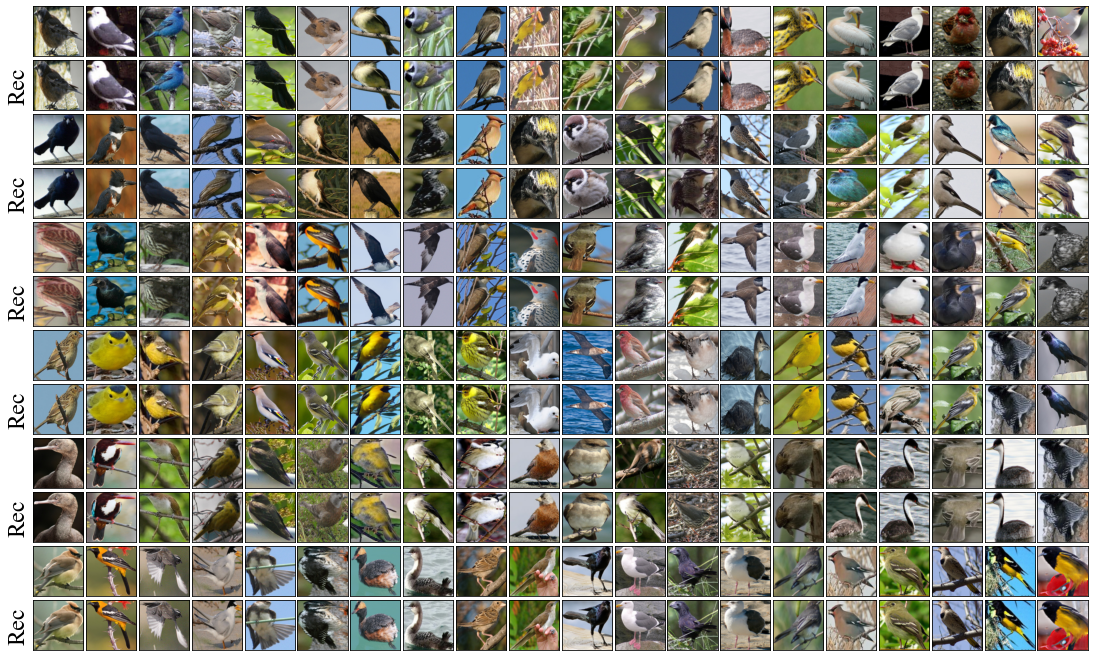

In [12]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgRecExtra.pdf'), dpi=300)

In [13]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [14]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      large bird , small beak and head , brown and white and black .
Rec:  small bird with black belly and crown and and white on its body .
      this bird has wings that are grey and has a white belly .
Rec:  this bird has wings that are grey and has a white belly .
      the bird has a blue crown with white bill .
Rec:  this bird has a black crown and black bill .
      this small plump bird has a black and white breast and white eyebrows .
Rec:  a small brown bird has a long pointed beak body and white wings .
      this is an all black bird with wide rectrices and a tall , sharp bill .
Rec:  this is a all black bird with black wings and a short , pointed bill .
      a small light and dark brown bird with a short sharp beak with small round black eyes .
Rec:  this small small white and and bird bird with brown brown and and and very brown bill .
      this bird has a brown crown as well as a white belly .
Rec:  this bird has a brown crown as well as a white belly .
      a small b

In [15]:
with open(os.path.join(PATH, 'CUBTxtRec.txt'), 'w') as file:
    for sent, sent_h in zip(sents, sents_h):
        file.write('Ref: ' + sent + '\n')
        file.write('Rec: ' + sent_h + '\n')

### Cross Generation

#### Image -> Caption

In [16]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), None])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

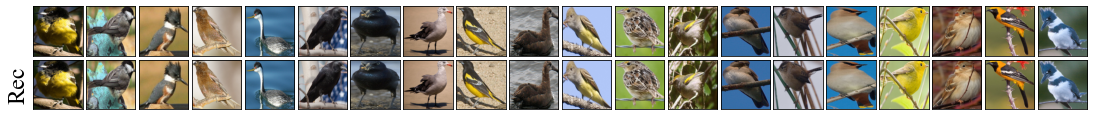

In [17]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgX_Img2Txt.pdf'), dpi=300)

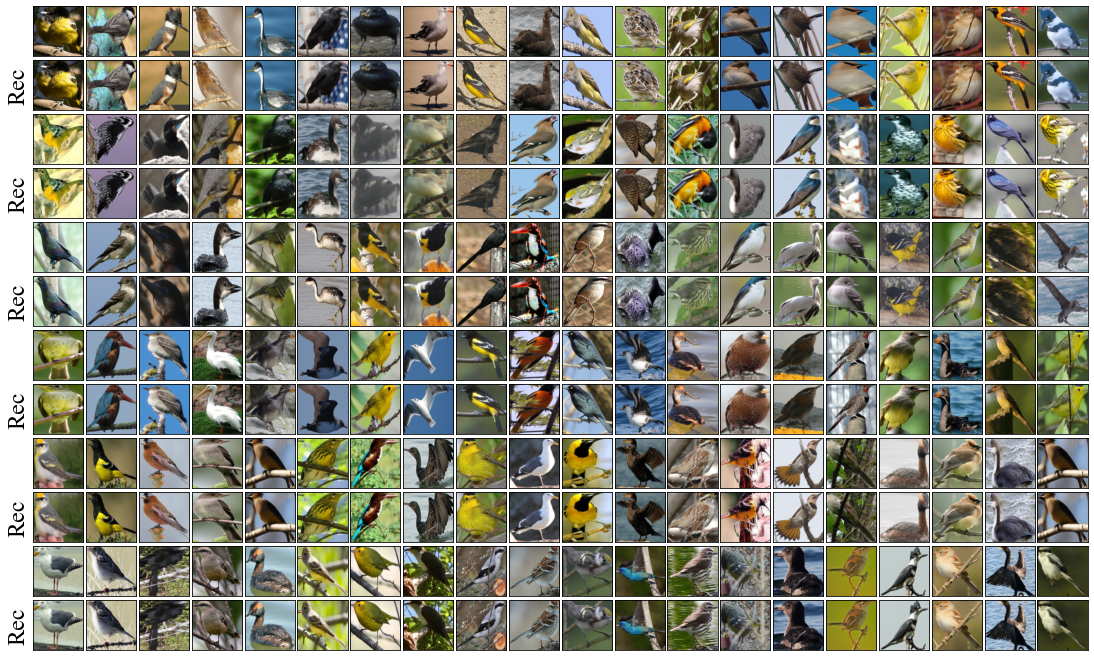

In [18]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgX_Img2TxtExtra.pdf'), dpi=300)

In [19]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [20]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      this bird has a black crown , yellow breast , and a yellow belly .
Rec:  this bird is yellow with black on its head and a with a short beak .
      a bird with a mini pointed beak and a black colored crown , also has a grayish cheek patch .
Rec:  this bird is white , white , in black in a black sharp beak beak and and eye rings .
      this particular bird has a belly that is white and orange .
Rec:  this bird has a black body , a long and black , and a and a white breast .
      this bird has wings that are brown and has a small bill .
Rec:  this is colorful bird with a white belly and brown wings .
      this bird has wings that are brown and has a long neck .
Rec:  this is a small brown bird with a white beak and a round on on head .
      a dark black bird with a yellowish beak and black eyes .
Rec:  this is a all black bird with a black crown , a a black beak .
      this bird is black in color with a black beak , and white eye rings .
Rec:  this bird is black with red and h

In [21]:
with open(os.path.join(PATH, 'CUBTxtX_Img2Txt.txt'), 'w') as file:
    for sent, sent_h in zip(sents, sents_h):
        file.write('Ref: ' + sent + '\n')
        file.write('Rec: ' + sent_h + '\n')

#### Image <- Caption

In [22]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([None, txt.to(device)])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

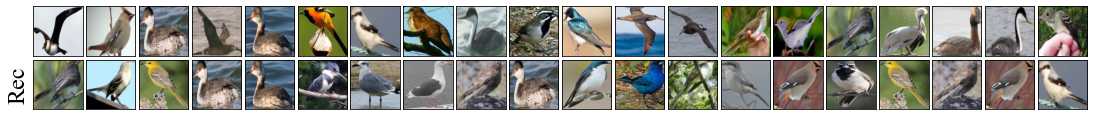

In [23]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgX_Txt2Img.pdf'), dpi=300)

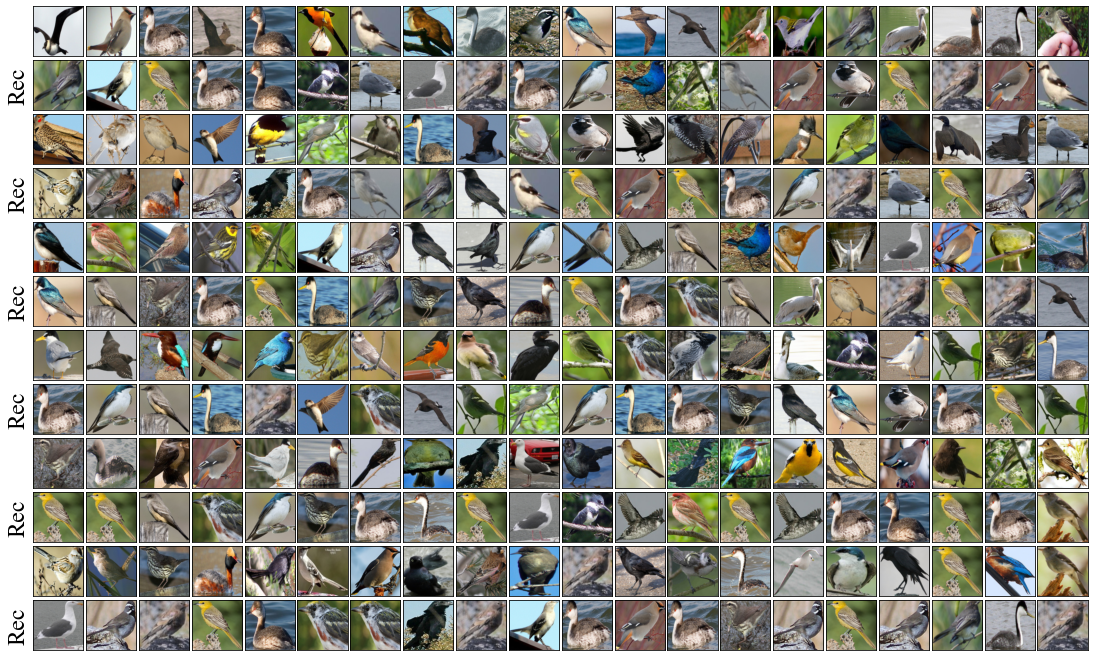

In [24]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgX_Txt2ImgExtra.pdf'), dpi=300)

In [25]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

sents = []
for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    sents.append(' '.join(sent))

In [26]:
for sent, sent_h in zip(sents, sents_h):
    print('     ', sent)
    print('Rec: ', sent_h)

      this bird has long black triangular wings , a white belly , and a black crown .
Rec:  this bird has a very pointed throat , a brown belly , and a grey belly .
      this bird is white , brown , and black in color , and has a sharp beak .
Rec:  this bird is white , black , and black in color , and has a black beak ring . <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
      this bird is white and black in color and has a short white bill along with a red eye ring .
Rec:  this bird is white and brown in color , with a a black beak along a a black eye ring .
      this bird is large with a mostly grey body with a slightly lighter tone and large bill .
Rec:  this bird is brown with a brown feathers , , its its brown and and brown color .
      a large bird with red eyes and a long neck and black bill , it 's crown and back are grey .
Rec:  a large bird with brown eyes , a white beak and brown , and and and and and brown and and . .
      a petite bird , 

In [27]:
with open(os.path.join(PATH, 'CUBTxtX_Txt2Img.txt'), 'w') as file:
    for sent, sent_h in zip(sents, sents_h):
        file.write('Ref: ' + sent + '\n')
        file.write('Rec: ' + sent_h + '\n')

### Joint Generation

In [28]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([None, None])
        x_rec = results['x_rec']
        x_rec = [x_rec[0].loc, x_rec[1].probs.argmax(dim=1).reshape(x_rec[0].loc.shape[0], -1)]
        dist, idx_h = NN_lookup(x_rec[0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

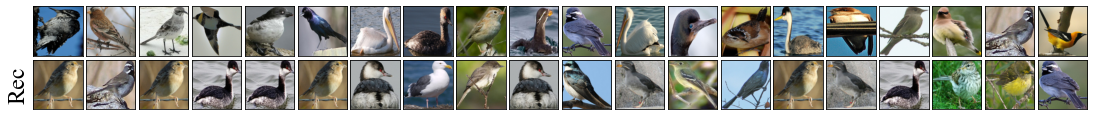

In [29]:
ncols = min(len(imgs_h), 20)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(15, 1.5))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgJointGen.pdf'), dpi=300)

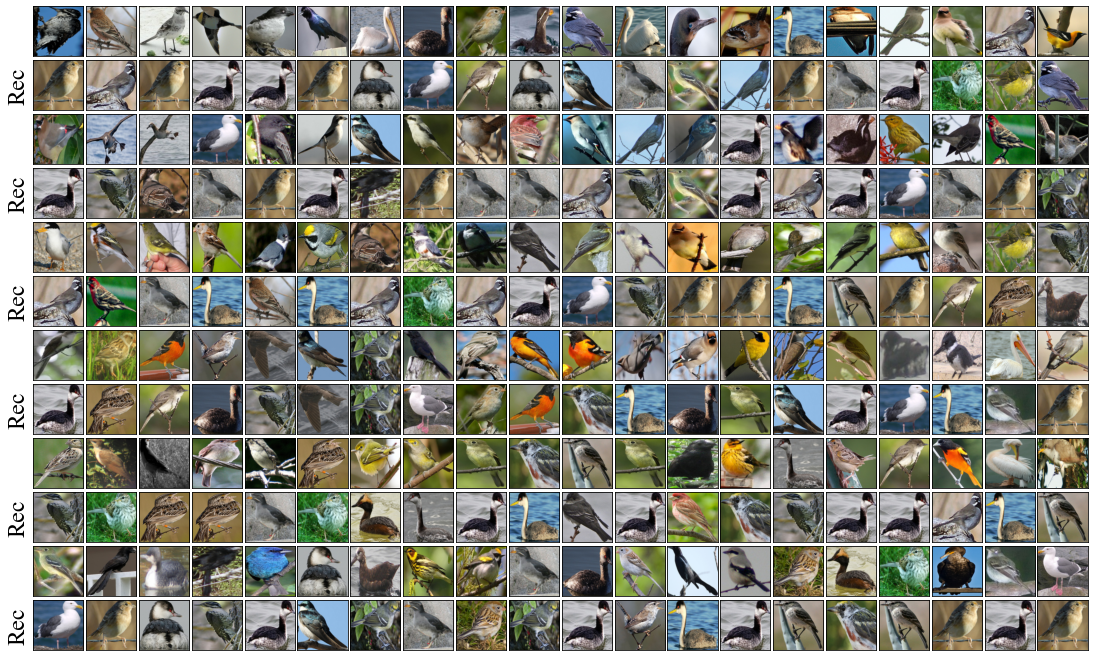

In [30]:
ncols = min(len(imgs_h), 20)
nrows = 2 * int(np.floor(len(imgs_h) / 20))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 1.5*nrows/2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= nrows / 2 * 20:
        break
    for j, im in enumerate(aux):
        ax[j+i//20*2, i%20].imshow(im.permute(1, 2, 0))
        ax[j+i//20*2, i%20].set_xticks([])
        ax[j+i//20*2, i%20].set_yticks([])
    ax[1+i//20*2, 0].set_ylabel('Rec', fontsize=24)
fig.tight_layout(pad=0)
fig.savefig(os.path.join(PATH, 'CUBImgJointGenExtra.pdf'), dpi=300)

In [31]:
sents_h = []
sents_emb = x_rec[1]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

In [32]:
for sent, sent_h in zip(sents, sents_h):
    print('Rec: ', sent_h)

Rec:  this bird is white in color with and very in beak , with a black eye beak
Rec:  this bird has a brown crown , a black bill , and a brown rings .
Rec:  this bird has brown white belly and brown , , a a and and , and a orange beak .
Rec:  this is swimming brown brown and brown bird with brown brown , and neck and a a black beak .
Rec:  this is a brown bird with a light brown , a beak , , a and a brown body on the brown , the and and , .
Rec:  this is of medium bird bird is , a , , , the , , and a and and and and and the the the the and and the and and
Rec:  this bird is black with white and has a in short beak . a black <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Rec:  this is a large grey bird , dark white and and and small pointy beak .
Rec:  this is a small bird with white with a white , .
Rec:  this bird bird is mostly white white with the brown body the , and , and and , and and and and white black white the . <pad> <pa

In [33]:
with open(os.path.join(PATH, 'CUBTxtJointGen.txt'), 'w') as file:
    for sent, sent_h in zip(sents, sents_h):
        file.write('Rec: ' + sent_h + '\n')